##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import tensorflow as tf
import wandb 

mpl.rcParams["figure.figsize"] = (8, 6)
mpl.rcParams["axes.grid"] = False

2024-01-23 11:43:52.156260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
tf.config.list_physical_devices("GPU")

Num GPUs Available:  0


2024-01-23 11:44:00.785262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-23 11:44:00.785299: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-23 11:44:00.785314: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l40059.lvt.dkrz.de): /proc/driver/nvidia/version does not exist


[]

## The weather dataset


In [4]:
fp = "station_output.nc"
ds = xr.open_dataset(fp)
ds

<xarray.Dataset>
Dimensions:       (station_name: 2, Time: 345601)
Coordinates:
  * Time          (Time) datetime64[ns] 2019-04-03T00:01:00 ... 2019-11-29T00...
    lat           (station_name) float32 ...
    lon           (station_name) float32 ...
  * station_name  (station_name) object 'Pout' 'Dakar'
Data variables:
    T2            (station_name, Time) float32 ...
    RAIN_1MIN     (station_name, Time) float32 ...
    Q2            (station_name, Time) float32 ...
    SMOIS         (station_name, Time) float32 ...
    U10           (station_name, Time) float32 ...
    V10           (station_name, Time) float32 ...
    PSFC          (station_name, Time) float32 ...
Attributes:
    Conventions:  CF-1.9

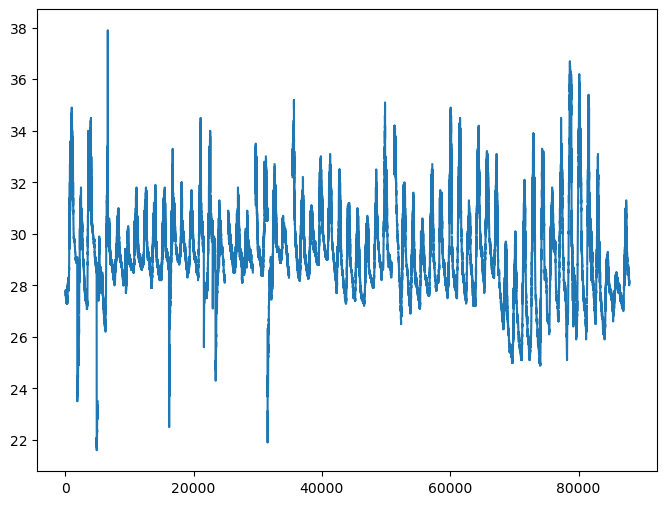

In [5]:
fp_dakar = "Dakar_3month.csv"
ds_dakar = pd.read_csv(fp_dakar)
ds_dakar
ds_dakar = ds_dakar[ds_dakar.Timestamp.between('2023-09-22', '2023-11-22')]
ds_dakar

#fp_pout = "Pout_3month.csv"
#ds_pout = pd.read_csv(fp_pout)
#ds_pout
#ds_dakar = ds_dakar[ds_dakar.Timestamp.between('2023-09-22', '2023-11-22')]
#ds_dakar

plt.plot(ds_dakar['19041.metergroup-atmos41-air-temperature'])

In [6]:
datasets = []
for station_name in ["Pout", "Dakar"]:
    ds_station = ds.sel(station_name=station_name)
    var_names = list(ds.data_vars)
    ds_station = ds_station.rename({v: f"{v}__{station_name}" for v in var_names})
    for c in ["lat", "lon"]:
        da_coord = ds_station[c].item()
        ds_station = ds_station.drop_vars(c)
        new_name = f"{c}__{station_name}"
        ds_station[new_name] = da_coord

    ds_station = ds_station.drop("station_name")
    datasets.append(ds_station)

ds_renamed_vars = xr.merge(datasets)
ds_renamed_vars

<xarray.Dataset>
Dimensions:           (Time: 345601)
Coordinates:
  * Time              (Time) datetime64[ns] 2019-04-03T00:01:00 ... 2019-11-2...
Data variables: (12/18)
    T2__Pout          (Time) float32 ...
    RAIN_1MIN__Pout   (Time) float32 ...
    Q2__Pout          (Time) float32 ...
    SMOIS__Pout       (Time) float32 ...
    U10__Pout         (Time) float32 ...
    V10__Pout         (Time) float32 ...
    ...                ...
    SMOIS__Dakar      (Time) float32 ...
    U10__Dakar        (Time) float32 ...
    V10__Dakar        (Time) float32 ...
    PSFC__Dakar       (Time) float32 ...
    lat__Dakar        float64 14.73
    lon__Dakar        float64 -17.47
Attributes:
    Conventions:  CF-1.9

In [7]:
#ds_subset = ds_renamed_vars.sel(Time=slice('2019-08-01T00:00:00','2019-10-30T00:00:00'))

#ds_subset = ds_renamed_vars.isel(Time=slice(None, None, 5))
#ds_subset = ds_renamed_vars.isel(Time=slice(None, None, 60))
ds_subset = ds_renamed_vars.resample(Time='15min').mean('Time') #1H
ds_subset

<xarray.Dataset>
Dimensions:           (Time: 23041)
Coordinates:
  * Time              (Time) datetime64[ns] 2019-04-03 ... 2019-11-29
Data variables: (12/18)
    T2__Pout          (Time) float32 293.4 293.2 293.0 ... 306.6 306.2 305.9
    RAIN_1MIN__Pout   (Time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Q2__Pout          (Time) float32 0.01206 0.01209 ... 0.009881 0.009981
    SMOIS__Pout       (Time) float32 0.02999 0.02999 0.02999 ... 0.03042 0.03042
    U10__Pout         (Time) float32 1.02 1.013 1.013 1.082 ... 1.84 1.727 1.664
    V10__Pout         (Time) float32 -5.786 -5.655 -5.597 ... -5.769 -5.794
    ...                ...
    SMOIS__Dakar      (Time) float32 0.03 0.03 0.03 ... 0.03088 0.03088 0.03088
    U10__Dakar        (Time) float32 1.208 1.095 0.87 ... 0.5575 0.6354 0.641
    V10__Dakar        (Time) float32 -6.766 -6.68 -6.549 ... -5.149 -5.196 -5.21
    PSFC__Dakar       (Time) float32 1.01e+05 1.01e+05 ... 1.006e+05 1.006e+05
    lat__Dakar        (Time) float64 14.73 14.73 14.73 ... 14.73 14.73 14.73
    lon__Dakar        (Time) float64 -17.47 -17.47 -17.47 ... -17.47 -17.47
Attributes:
    Conventions:  CF-1.9

In [8]:
df = ds_subset.to_dataframe()
df.to_csv('WRF-15min.csv')

Let's take a glance at the data. Here are the first few rows:

In [9]:
df.head()

,T2__Pout,RAIN_1MIN__Pout,Q2__Pout,SMOIS__Pout,U10__Pout,V10__Pout,PSFC__Pout,lat__Pout,lon__Pout,T2__Dakar,RAIN_1MIN__Dakar,Q2__Dakar,SMOIS__Dakar,U10__Dakar,V10__Dakar,PSFC__Dakar,lat__Dakar,lon__Dakar
Time,,,,,,,,,,,,,,,,,,
2019-04-03 00:00:00,293.397491,0.0,0.012056,0.029992,1.019841,-5.785992,101017.960938,14.761833,-17.06885,293.927521,0.0,0.012389,0.03,1.207953,-6.766141,101021.523438,14.725876,-17.468525
2019-04-03 00:15:00,293.156616,0.0,0.012086,0.029992,1.013251,-5.654546,101004.718750,14.761833,-17.06885,293.885651,0.0,0.012280,0.03,1.094645,-6.679965,101002.734375,14.725876,-17.468525
2019-04-03 00:30:00,292.978363,0.0,0.012124,0.029992,1.013287,-5.596679,100972.406250,14.761833,-17.06885,293.721161,0.0,0.012282,0.03,0.869975,-6.548854,100965.843750,14.725876,-17.468525
2019-04-03 00:45:00,292.887817,0.0,0.012151,0.029992,1.081674,-5.597273,100989.976562,14.761833,-17.06885,293.576477,0.0,0.012408,0.03,0.689731,-6.265708,100981.765625,14.725876,-17.468525
2019-04-03 01:00:00,292.773621,0.0,0.012249,0.029992,1.042502,-5.753339,101002.625000,14.761833,-17.06885,293.504730,0.0,0.012448,0.03,0.470023,-5.975224,100999.984375,14.725876,-17.468525


Here is the evolution of a few features over time:

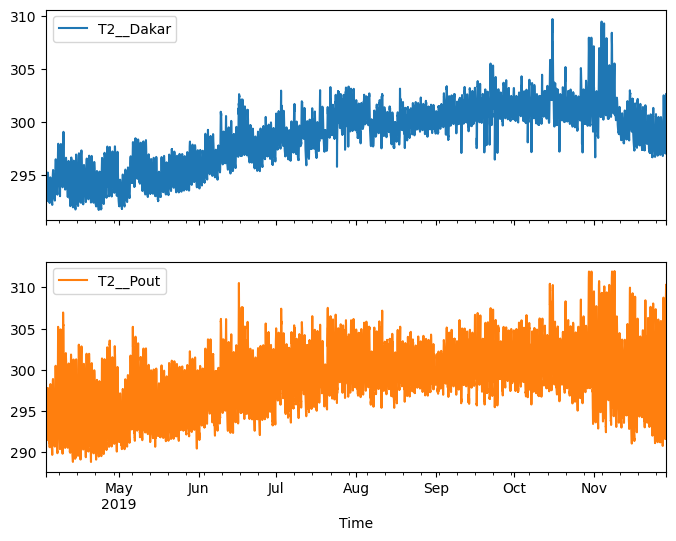

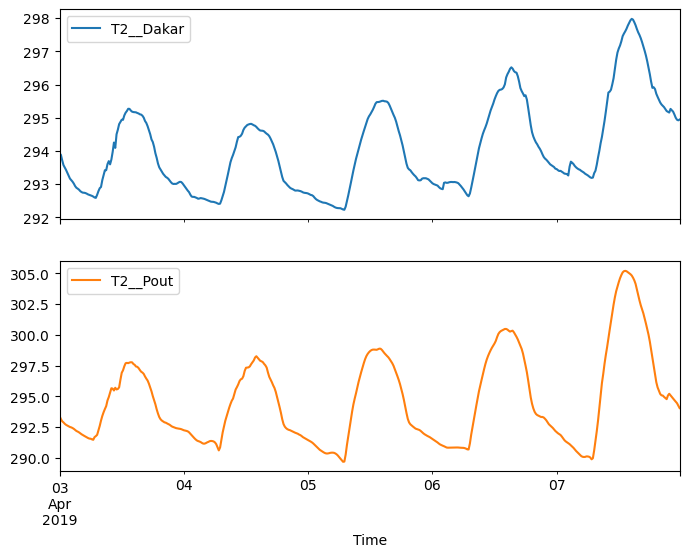

In [10]:
plot_cols = ["T2__Dakar", "T2__Pout"]
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
_ = plot_features.plot(subplots=True)

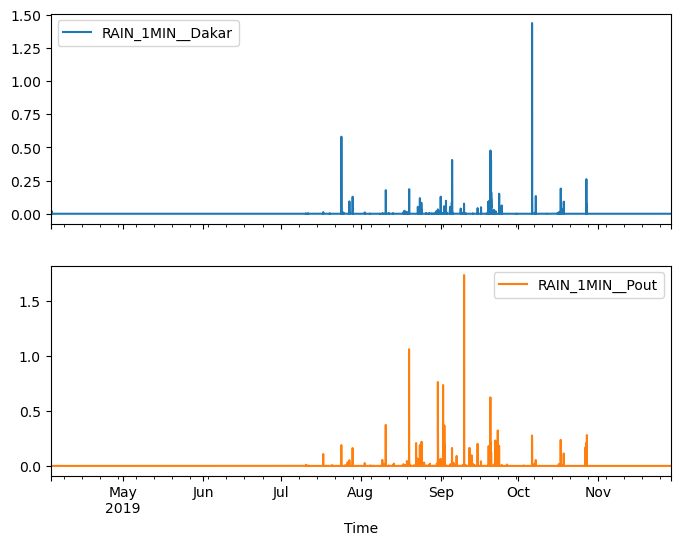

In [101]:
plot_cols = ["RAIN_1MIN__Dakar", "RAIN_1MIN__Pout"]
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

#plot_features = df[plot_cols][-480:-1]
#_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next, look at the statistics of the dataset:

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
T2__Pout,23041.0,298.774963,4.157055,288.823608,295.912292,298.853699,301.739258,311.968903
RAIN_1MIN__Pout,23041.0,0.001002,0.019546,-0.000592,0.000000,0.000000,0.000000,1.738724
Q2__Pout,23041.0,0.014988,0.003288,0.003352,0.012608,0.015260,0.017772,0.021238
SMOIS__Pout,23041.0,0.030098,0.000180,0.029992,0.029992,0.029992,0.030176,0.030425
U10__Pout,23041.0,1.839627,1.973095,-10.303247,0.795473,2.031733,3.149191,7.144516
V10__Pout,23041.0,-2.103127,2.984754,-9.585388,-4.251698,-2.284600,-0.065218,9.764972
PSFC__Pout,23041.0,100742.406250,157.387863,100045.992188,100640.843750,100751.140625,100849.445312,101380.632812
lat__Pout,23041.0,14.761833,0.000000,14.761833,14.761833,14.761833,14.761833,14.761833
lon__Pout,23041.0,-17.068850,0.000000,-17.068850,-17.068850,-17.068850,-17.068850,-17.068850
T2__Dakar,23041.0,298.640411,3.047764,291.752228,296.493561,299.202057,300.821869,309.709564


### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [13]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)

In [14]:
df["RAIN_cumulative__Dakar"]=df["RAIN_1MIN__Dakar"].cumsum()
df["RAIN_cumulative__Pout"]=df["RAIN_1MIN__Pout"].cumsum()


11.323478

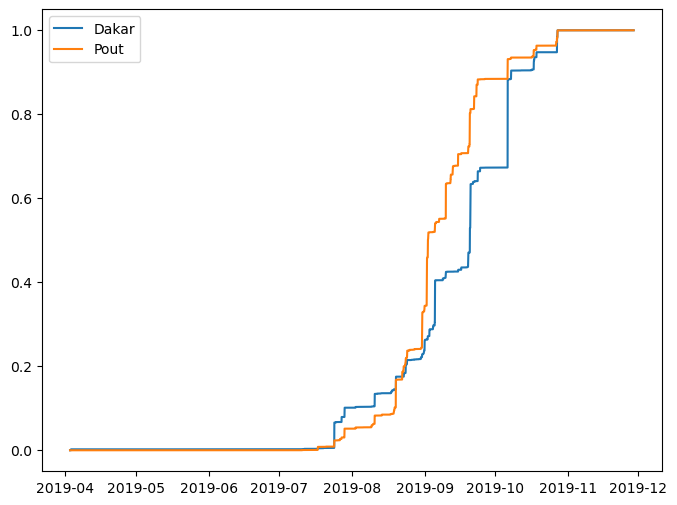

In [15]:
plt.plot(df["RAIN_cumulative__Dakar"]/df["RAIN_cumulative__Dakar"][-1], label='Dakar')
plt.plot(df["RAIN_cumulative__Pout"]/df["RAIN_cumulative__Pout"][-1], label='Pout')
plt.legend()
df["RAIN_cumulative__Dakar"][-1]

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [16]:
day =  24 * 60 * 60
year = (365.2425) * day

df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

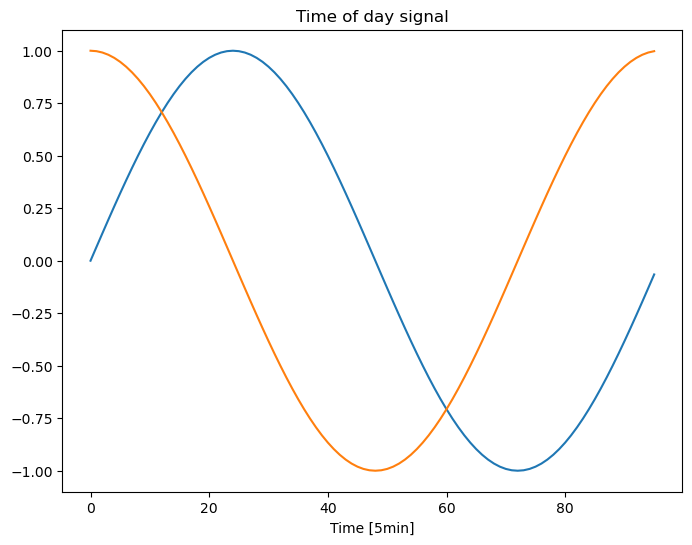

In [17]:
plt.plot(np.array(df["Day sin"])[:4*24])
plt.plot(np.array(df["Day cos"])[:4*24])
plt.xlabel("Time [5min]")
plt.title("Time of day signal")

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:


2024-01-23 11:47:28.539711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


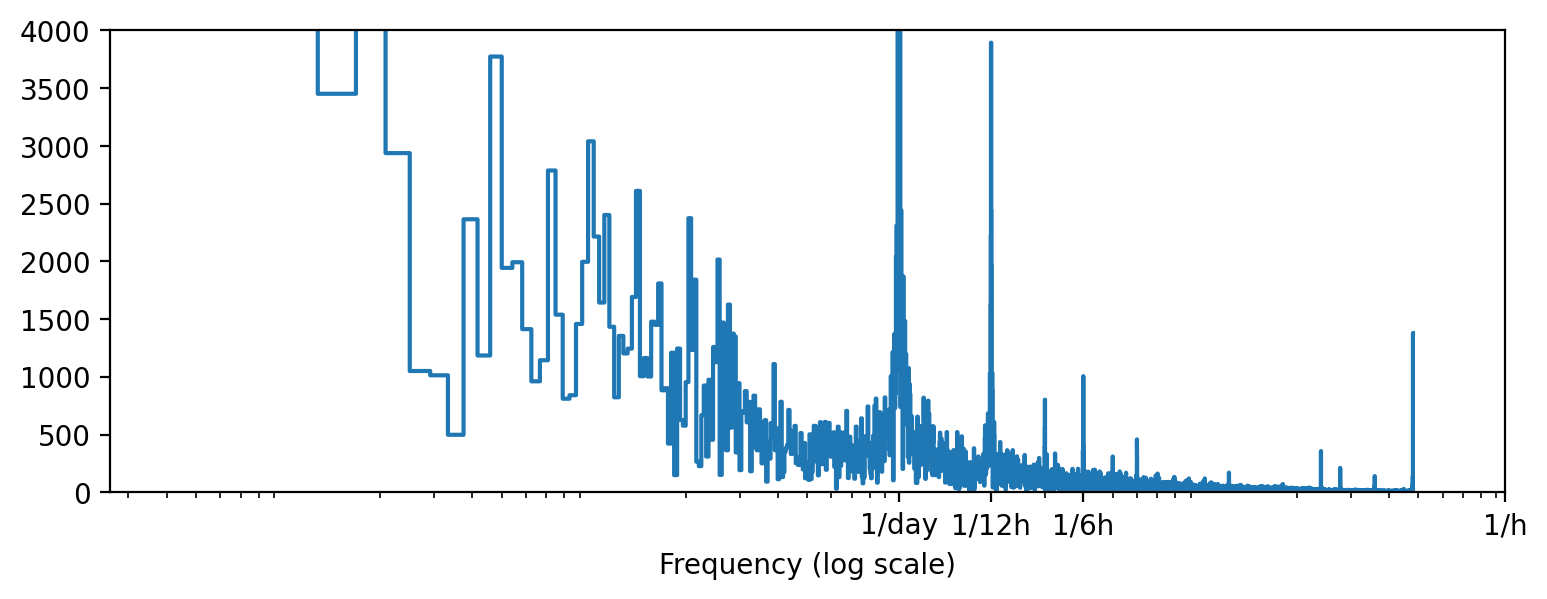

In [18]:
# for later, when dealing with 1 minute data
var_name = "T2__Dakar"
fft = tf.signal.rfft(df[var_name])
f_per_dataset = np.arange(0, len(fft))

n_samples = len(df[var_name])
hours_per_day = 24*4
#minutes_per_day = hours_per_day*60
days_per_dataset = n_samples/(hours_per_day)

f_per_day = f_per_dataset/days_per_dataset

plt.figure(figsize=(9,3),dpi=200)
plt.step(f_per_day, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 4000)
plt.xticks([1, 2, 4, hours_per_day], labels=['1/day','1/12h', '1/6h', '1/h'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [19]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [20]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

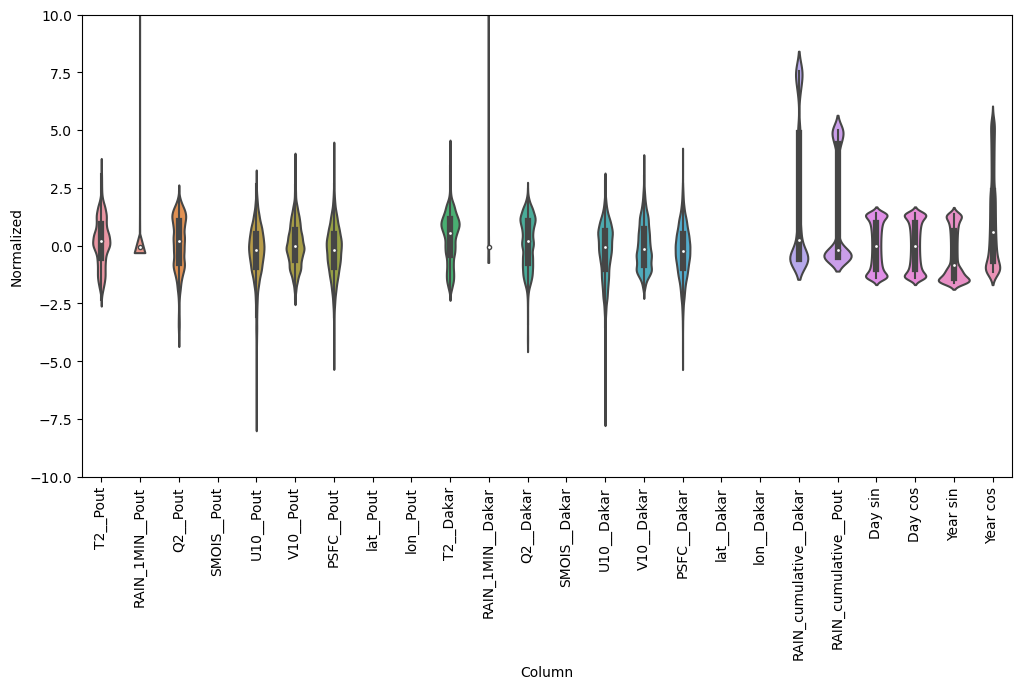

In [21]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)
_ = ax.set_ylim(-10,10)

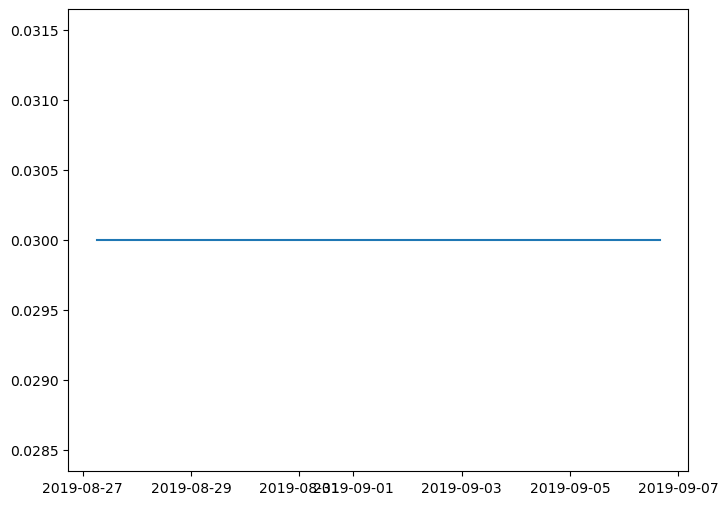

In [100]:
plt.plot(df["SMOIS__Dakar"][-9000:-8000])

In [22]:
from scipy import signal
x = df["T2__Pout"]
y = df["T2__Dakar"]
correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
lags = signal.correlation_lags(len(x), len(y), mode="full")
lag = lags[np.argmax(abs(correlation))]
lag
#plt.plot(correlation)

-1

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](images/raw_window_24h.png)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [23]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_columns=None,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        
        # Work out the input column indices.
        self.input_columns = input_columns
        if input_columns is not None:
            self.input_columns_indices = {
                name: i for i, name in enumerate(input_columns)
            }
         
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
            
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Input column name(s): {self.input_columns}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.input_columns is not None:
            inputs = tf.stack(
                [
                    inputs[:, :, self.column_indices[name]]
                    for name in self.input_columns
                ],
                axis=-1,
            )
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, plot_col_input='T2__Dakar', plot_col_label='T2__Dakar', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_input_index = self.input_columns_indices.get(plot_col_input, None) #self.column_indices[plot_col_input]
        plot_col_label_index = self.label_columns_indices.get(plot_col_label, None) #self.column_indices[plot_col_label]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col_input} [normed]")
                
            if self.input_columns:
                input_col_index = self.input_columns_indices.get(plot_col_input, None)
            else:
                input_col_index = plot_col_input_index

            if input_col_index is None:
                continue
                
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col_label, None)
            else:
                label_col_index = plot_col_label_index

            if label_col_index is None:
                continue

            
            plt.plot(
                self.input_indices,
                inputs[n, :, input_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )
                
            
            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k",
                label="Labels",
                c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [h]")

In [24]:
#print(multi_window.input_columns_indices)
#print(multi_window.input_columns_indices.get('T2__Dakar', None))
#print(multi_window.column_indices['T2__Dakar'])

## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [25]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, input_columns=["T2__Pout"], label_columns=["T2__Dakar"]
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Input column name(s): ['T2__Pout']
Label column name(s): ['T2__Dakar']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [26]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [27]:
class BaselineModel(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [28]:
baseline_model = BaselineModel()

baseline_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline_model.evaluate(single_step_window.val)
performance["Baseline"] = baseline_model.evaluate(single_step_window.test, verbose=0)

144/144 [==============================] - 0s 682us/step - loss: 0.6119 - mean_absolute_error: 0.6796


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [79]:
import wandb
import wandb.integration.keras

MAX_EPOCHS = 10


def compile_and_fit(model, window, patience=2):
    #wandb.init(
    #    # set the wandb project where this run will be logged
    #    project="dakar-nowcasting",

    #    # track hyperparameters and run metadata
    #    config={
    #        "architecture": model.__class__.__name__,
    #        "epochs": MAX_EPOCHS,
    #        },
    #    settings=wandb.Settings(disable_git=True)
    #)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    # wandb_callback = wandb.integration.keras.WandbCallback()

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping], # wandb_callback],
    )
    return history

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](images/lstm_1_window.png)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](images/lstm_many_window.png)

In [30]:
wide_window = WindowGenerator(
    input_width=16, 
    label_width=16, 
    shift=1, 
    input_columns=["T2__Dakar","T2__Pout", "Q2__Pout", "U10__Pout", "V10__Pout", "PSFC__Pout","RAIN_cumulative__Pout"],
    label_columns=["T2__Dakar"]
)

wide_window

Total window size: 17
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Input column name(s): ['T2__Dakar', 'T2__Pout', 'Q2__Pout', 'U10__Pout', 'V10__Pout', 'PSFC__Pout', 'RAIN_cumulative__Pout']
Label column name(s): ['T2__Dakar']

In [31]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(100, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [32]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 16, 7)
Output shape: (32, 16, 1)


In [33]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

144/144 [==============================] - 0s 2ms/step - loss: 0.0122 - mean_absolute_error: 0.0598


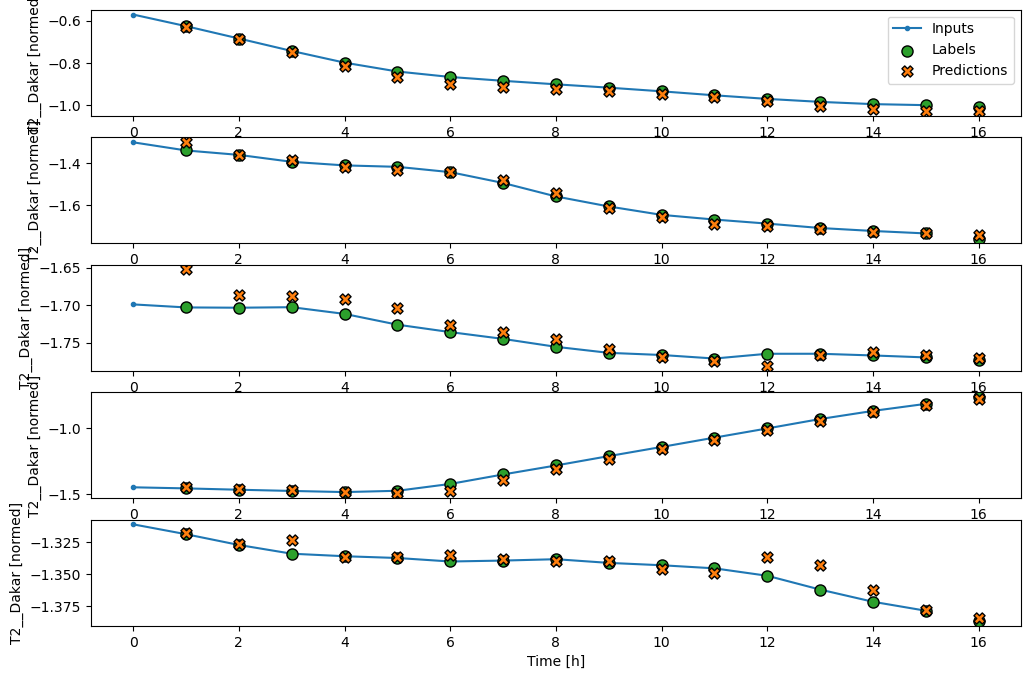

In [34]:
wide_window.plot(lstm_model,plot_col_input='T2__Dakar',plot_col_label='T2__Dakar',max_subplots=5)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

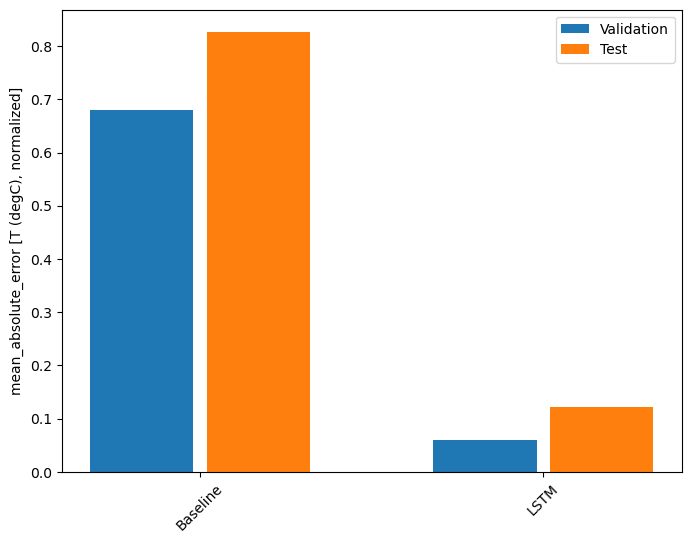

In [35]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [36]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.8271
LSTM        : 0.1212


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [37]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=16, 
    label_width=16, 
    shift=1,
    input_columns=["T2__Dakar", "Q2__Dakar","U10__Dakar", "V10__Dakar", "PSFC__Dakar","RAIN_cumulative__Dakar","T2__Pout", "Q2__Pout", "U10__Pout", "V10__Pout", "PSFC__Pout","RAIN_cumulative__Pout"],
    label_columns=["T2__Dakar", "Q2__Dakar","U10__Dakar", "V10__Dakar", "PSFC__Dakar","RAIN_cumulative__Dakar","T2__Dakar", "Q2__Dakar","U10__Dakar", "V10__Dakar", "PSFC__Dakar","RAIN_cumulative__Dakar"])

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 16, 12)
Labels shape (batch, time, features): (32, 16, 12)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [38]:
baseline_model = BaselineModel()
baseline_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [39]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline_model.evaluate(wide_window.val)
performance['Baseline'] = baseline_model.evaluate(wide_window.test, verbose=0)

144/144 [==============================] - 0s 602us/step - loss: 0.4554 - mean_absolute_error: 0.3453


#### RNN


In [40]:
%%time



lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(100, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=12)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

144/144 [==============================] - 0s 3ms/step - loss: 0.2697 - mean_absolute_error: 0.3107

CPU times: user 1min 24s, sys: 15.3 s, total: 1min 40s
Wall time: 23.6 s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [41]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [42]:
%%time
num_features=12
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

144/144 [==============================] - 0s 3ms/step - loss: 0.0540 - mean_absolute_error: 0.1314

CPU times: user 1min 24s, sys: 15.5 s, total: 1min 40s
Wall time: 23.1 s


#### Performance

Here is the overall performance for these multi-output models.

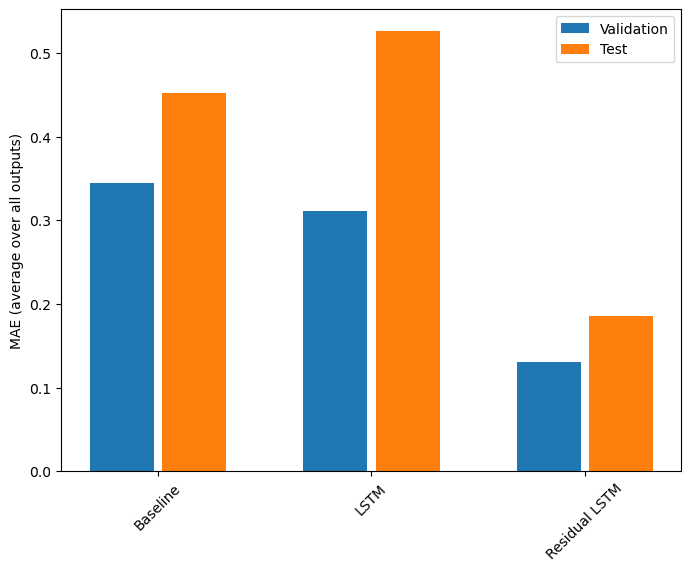

In [43]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [44]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.4524
LSTM           : 0.5259
Residual LSTM  : 0.1862


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 19
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [16 17 18]
Input column name(s): ['T2__Dakar', 'Q2__Dakar', 'U10__Dakar', 'V10__Dakar', 'PSFC__Dakar', 'RAIN_cumulative__Dakar', 'T2__Pout', 'Q2__Pout', 'U10__Pout', 'V10__Pout', 'PSFC__Pout', 'RAIN_cumulative__Pout']
Label column name(s): ['T2__Dakar']

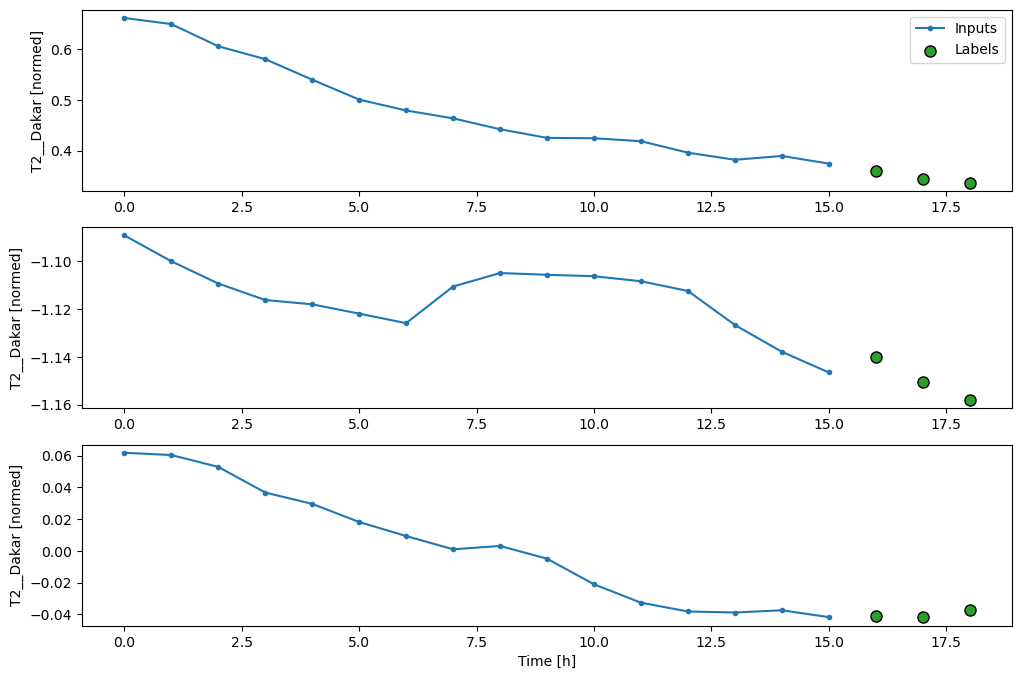

In [45]:
OUT_STEPS = 3
multi_window = WindowGenerator(input_width=16,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               input_columns=["T2__Dakar","Q2__Dakar", "U10__Dakar", "V10__Dakar", "PSFC__Dakar","RAIN_cumulative__Dakar","T2__Pout", "Q2__Pout", "U10__Pout", "V10__Pout", "PSFC__Pout", "RAIN_cumulative__Pout"],
                               label_columns=["T2__Dakar"]
)
num_features = 12
multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](images/multistep_last.png)

144/144 [==============================] - 0s 546us/step - loss: 6.0904 - mean_absolute_error: 1.7922


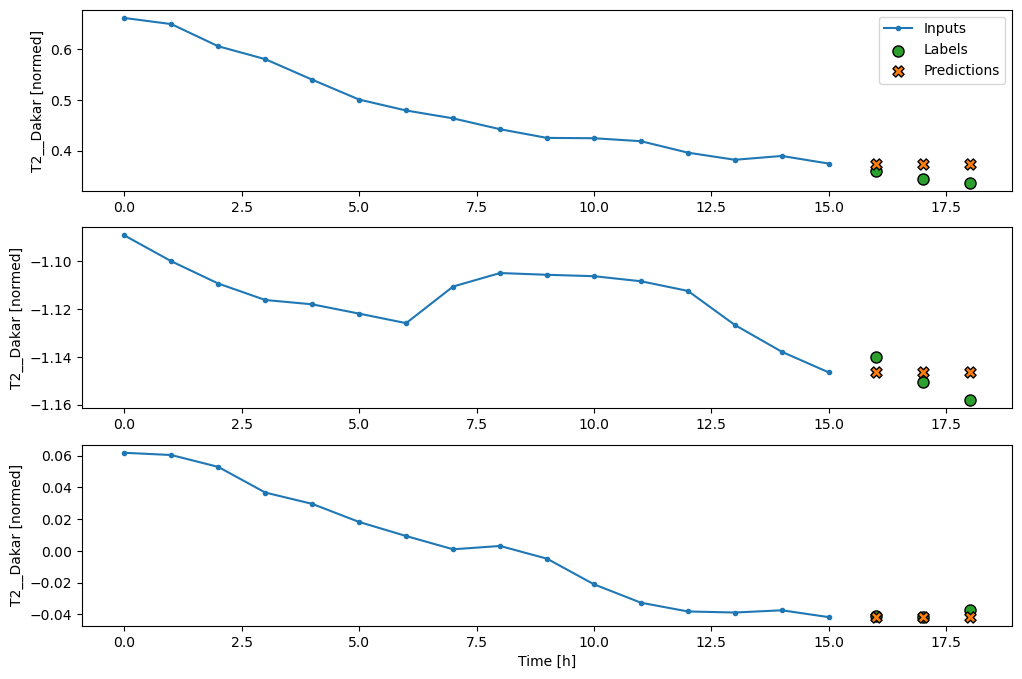

In [46]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](images/multistep_dense.png)

144/144 [==============================] - 0s 495us/step - loss: 0.0734 - mean_absolute_error: 0.1822


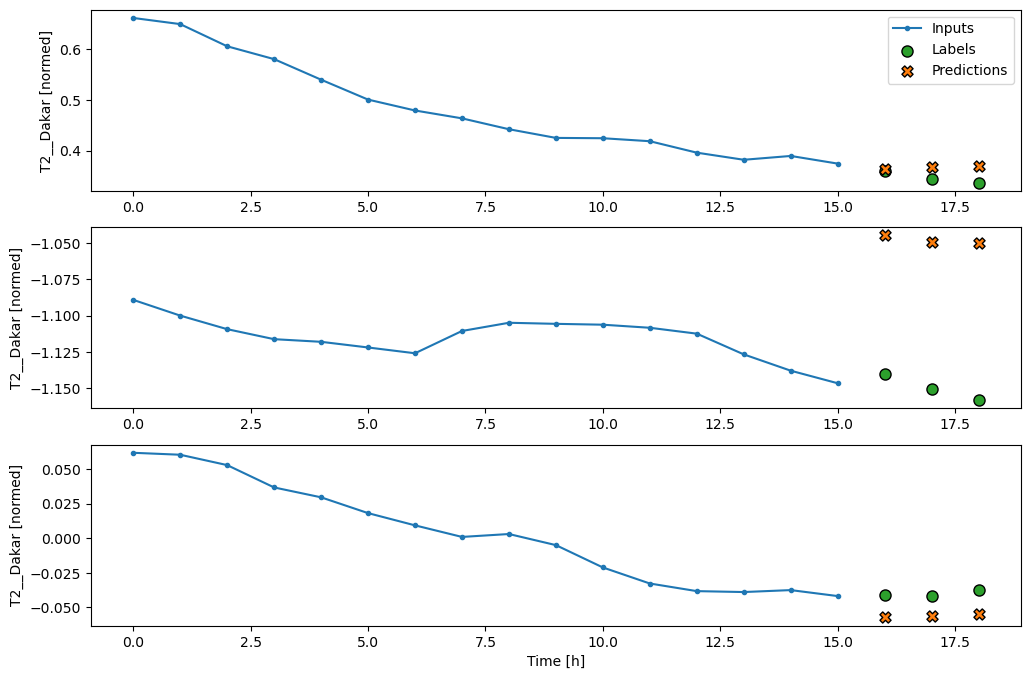

In [47]:
num_features=12
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [48]:
aa, bb = multi_linear_model.get_weights()
aa.shape, bb.shape

((12, 36), (36,))

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

144/144 [==============================] - 0s 615us/step - loss: 0.0211 - mean_absolute_error: 0.0864


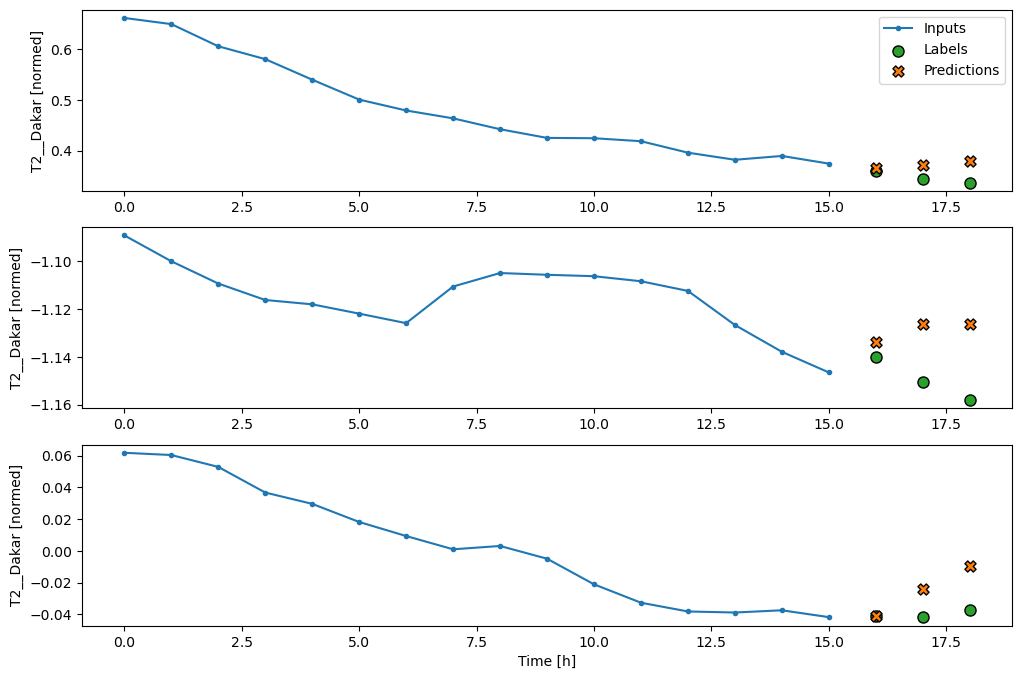

In [49]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

144/144 [==============================] - 0s 581us/step - loss: 0.0204 - mean_absolute_error: 0.0926


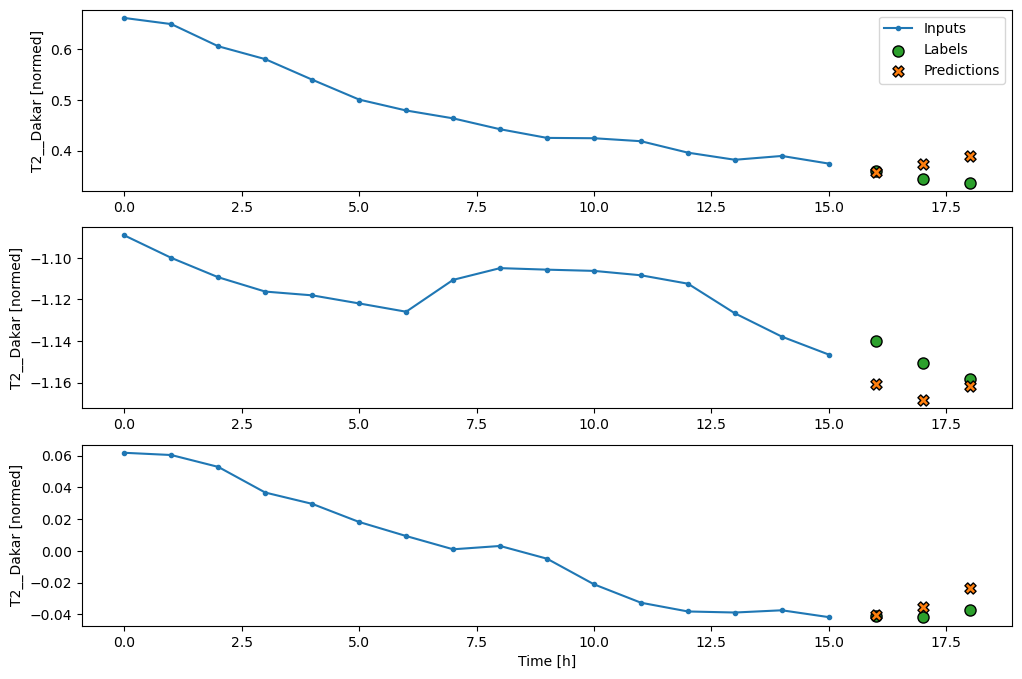

In [50]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](images/multistep_lstm.png)


Total window size: 19
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [16 17 18]
Input column name(s): ['T2__Dakar', 'Q2__Dakar', 'U10__Dakar', 'V10__Dakar', 'PSFC__Dakar']
Label column name(s): ['T2__Dakar']

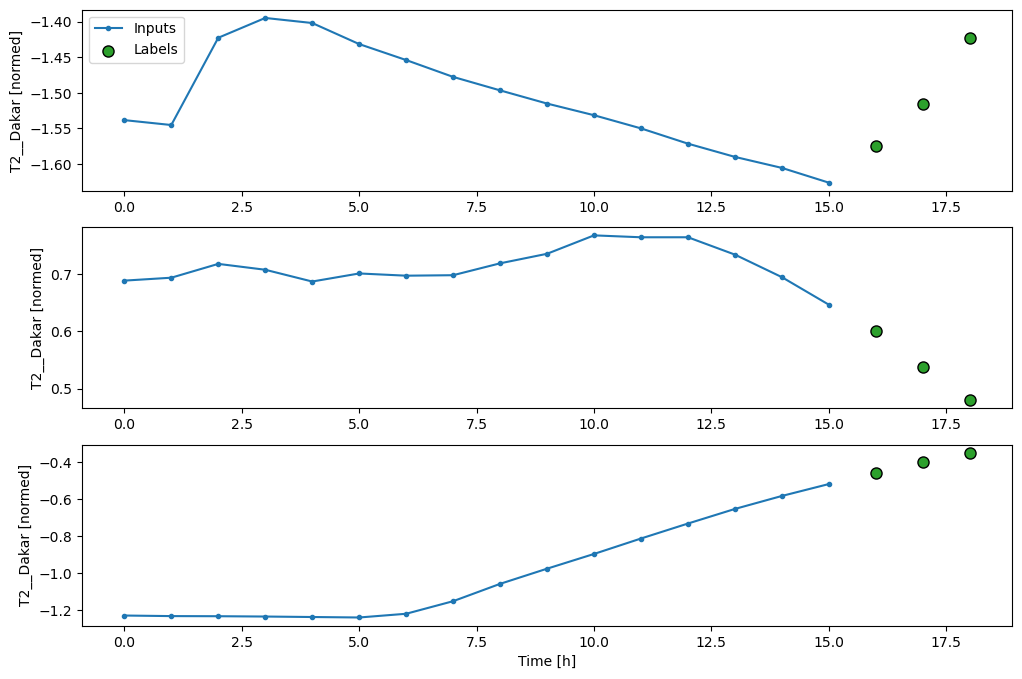

In [80]:
OUT_STEPS = 3
multi_window_dakaronly = WindowGenerator(input_width=16,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               input_columns=["T2__Dakar","Q2__Dakar", "U10__Dakar", "V10__Dakar", "PSFC__Dakar"],
                               label_columns=["T2__Dakar"]
)
num_features = 5
multi_window_dakaronly.plot()
multi_window_dakaronly

Total window size: 19
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [16 17 18]
Input column name(s): ['T2__Pout', 'Q2__Pout', 'U10__Pout', 'V10__Pout', 'PSFC__Pout']
Label column name(s): ['T2__Dakar']

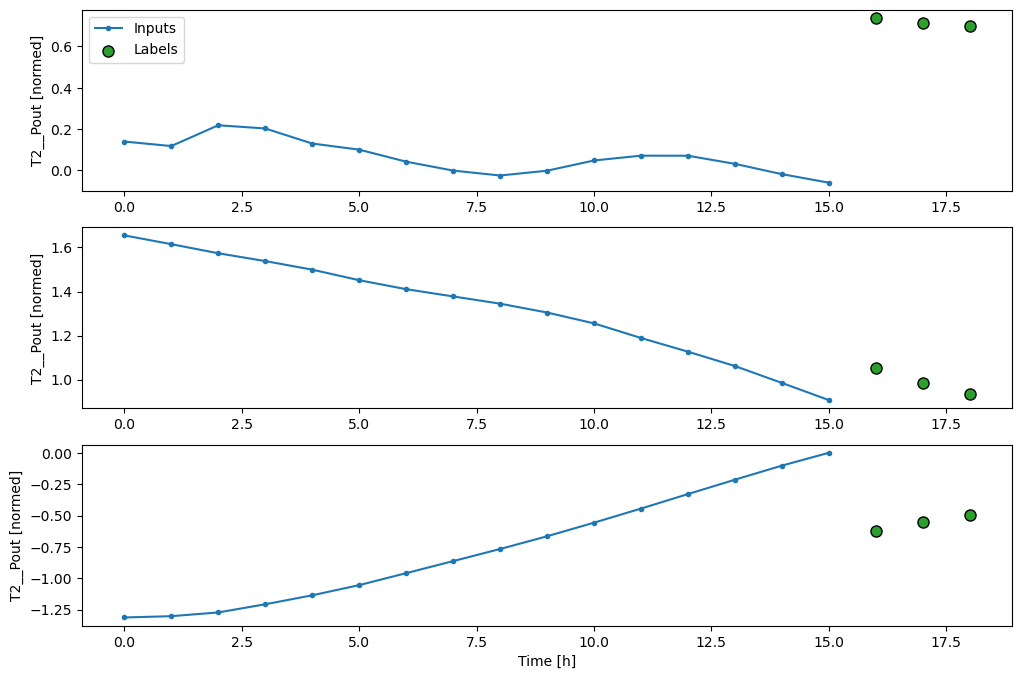

In [81]:
OUT_STEPS = 3
multi_window_poutonly = WindowGenerator(input_width=16,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               input_columns=["T2__Pout","Q2__Pout", "U10__Pout", "V10__Pout", "PSFC__Pout"],
                               label_columns=["T2__Dakar"]
)
num_features = 5
multi_window_poutonly.plot(plot_col_input='T2__Pout')
multi_window_poutonly

144/144 [==============================] - 0s 3ms/step - loss: 0.0247 - mean_absolute_error: 0.0958


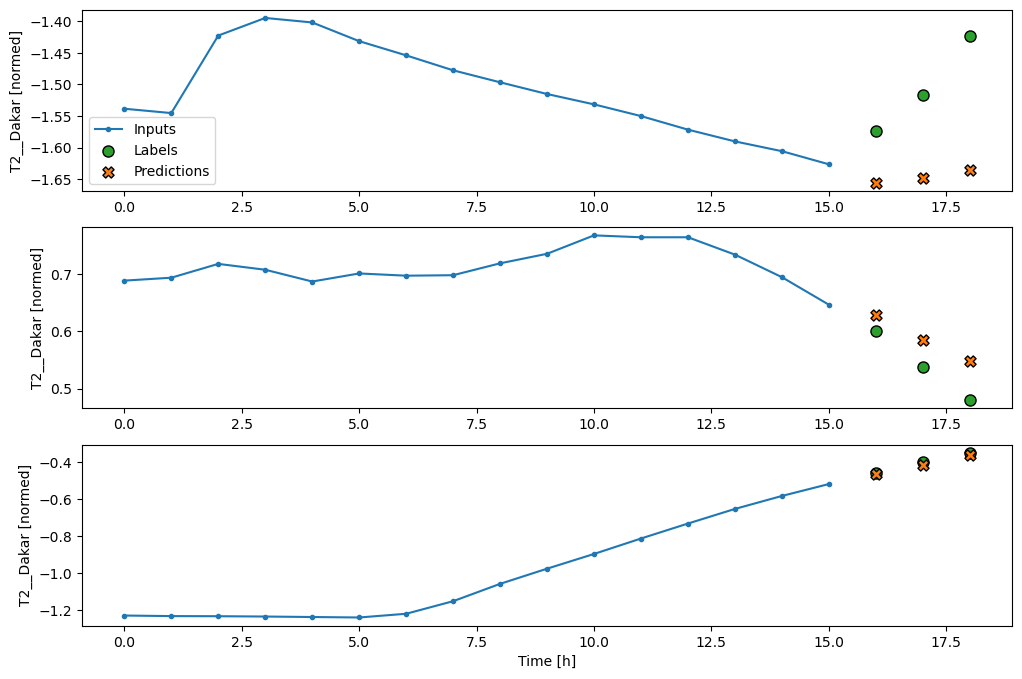

In [82]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(100, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_dakar = compile_and_fit(multi_lstm_model, multi_window_dakaronly)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_dakaronly.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_dakaronly.test, verbose=0)
multi_window_dakaronly.plot(multi_lstm_model)

144/144 [==============================] - 0s 2ms/step - loss: 0.3969 - mean_absolute_error: 0.3791


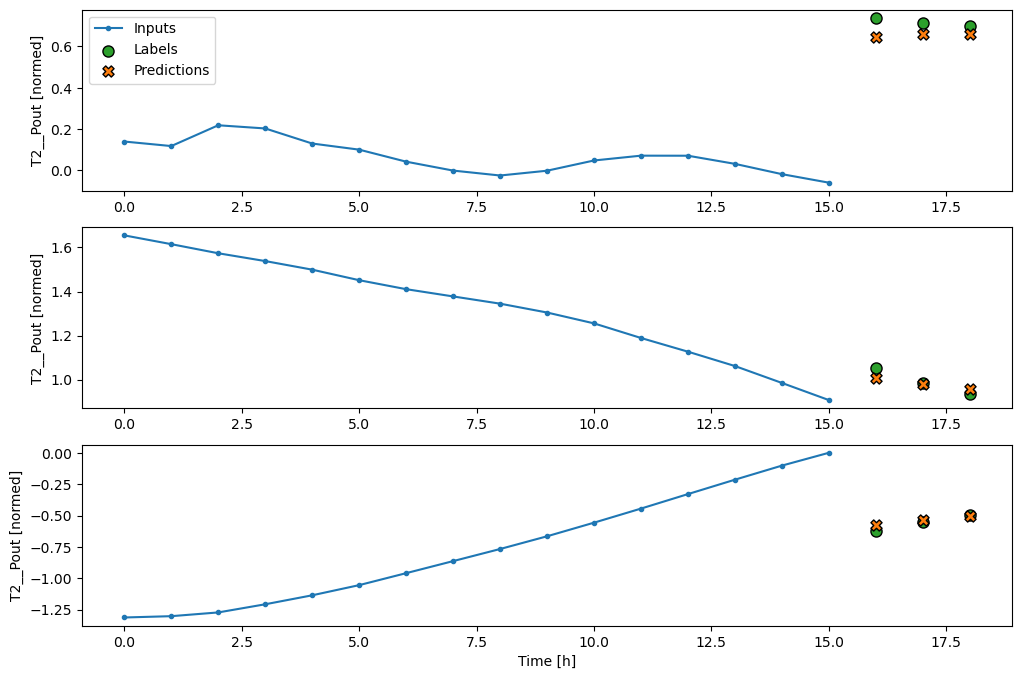

In [88]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(100, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_pout = compile_and_fit(multi_lstm_model, multi_window_poutonly)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_poutonly.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_poutonly.test, verbose=0)
multi_window_poutonly.plot(multi_lstm_model, plot_col_input='T2__Pout')

Total window size: 19
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [16 17 18]
Input column name(s): ['T2__Dakar', 'Q2__Dakar', 'U10__Dakar', 'V10__Dakar', 'PSFC__Dakar', 'T2__Pout', 'Q2__Pout', 'U10__Pout', 'V10__Pout', 'PSFC__Pout']
Label column name(s): ['T2__Dakar']

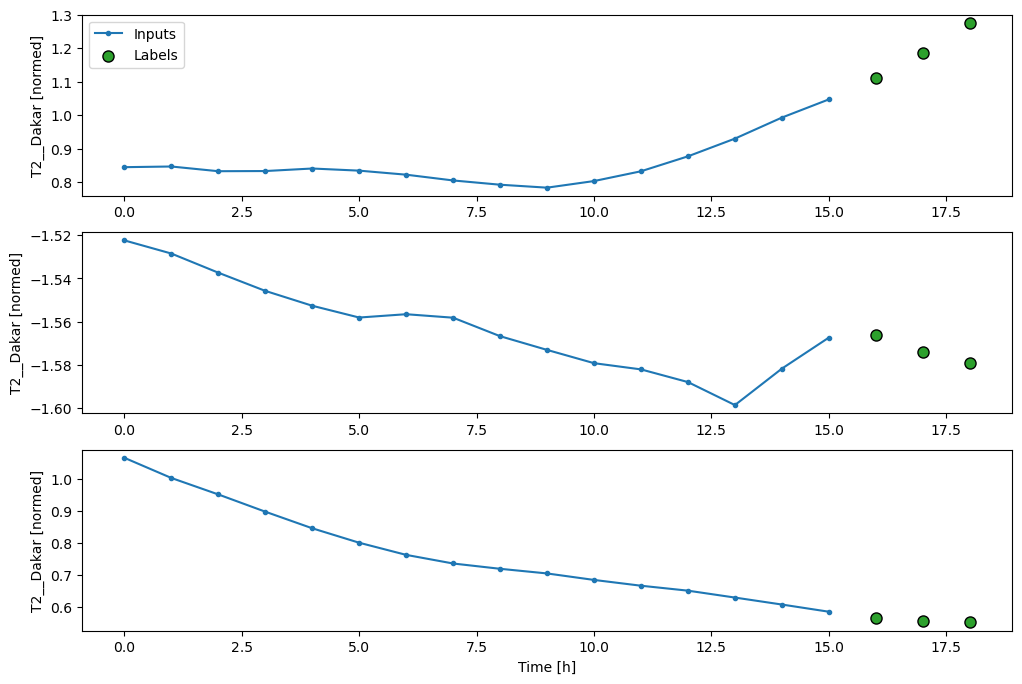

In [84]:
OUT_STEPS = 3
multi_window_dakarandpout = WindowGenerator(input_width=16,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               input_columns=["T2__Dakar","Q2__Dakar", "U10__Dakar", "V10__Dakar", "PSFC__Dakar","T2__Pout","Q2__Pout", "U10__Pout", "V10__Pout", "PSFC__Pout"],
                               label_columns=["T2__Dakar"]
)
num_features = 10
multi_window_dakarandpout.plot()
multi_window_dakarandpout

144/144 [==============================] - 0s 3ms/step - loss: 0.0300 - mean_absolute_error: 0.0990


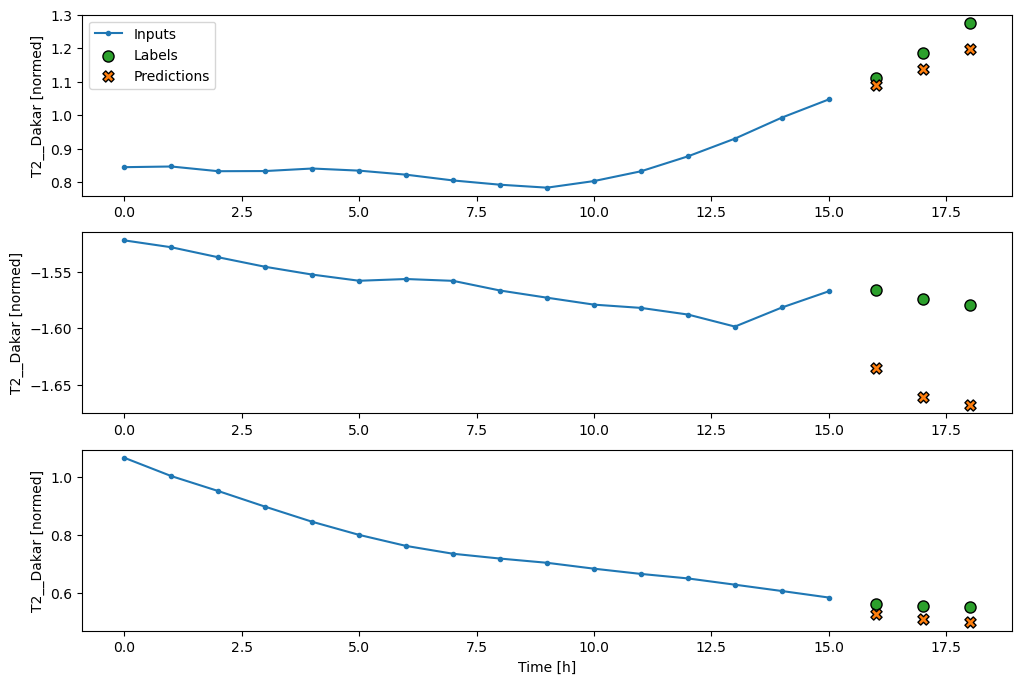

In [85]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(100, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_dakarandpout = compile_and_fit(multi_lstm_model, multi_window_dakarandpout)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_dakarandpout.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window_dakarandpout.test, verbose=0)
multi_window_dakarandpout.plot(multi_lstm_model)

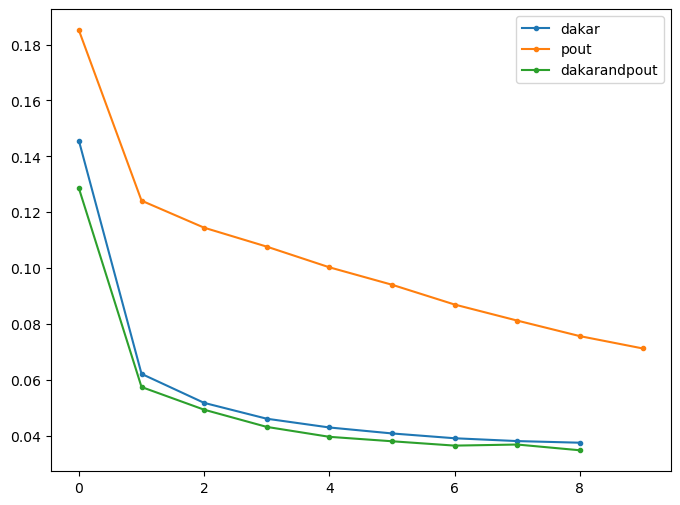

In [89]:
plt.plot(history_dakar.history['mean_absolute_error'], marker=".", label='dakar')
plt.plot(history_pout.history['mean_absolute_error'], marker=".", label='pout')
plt.plot(history_dakarandpout.history['mean_absolute_error'], marker=".", label='dakarandpout')
plt.legend()

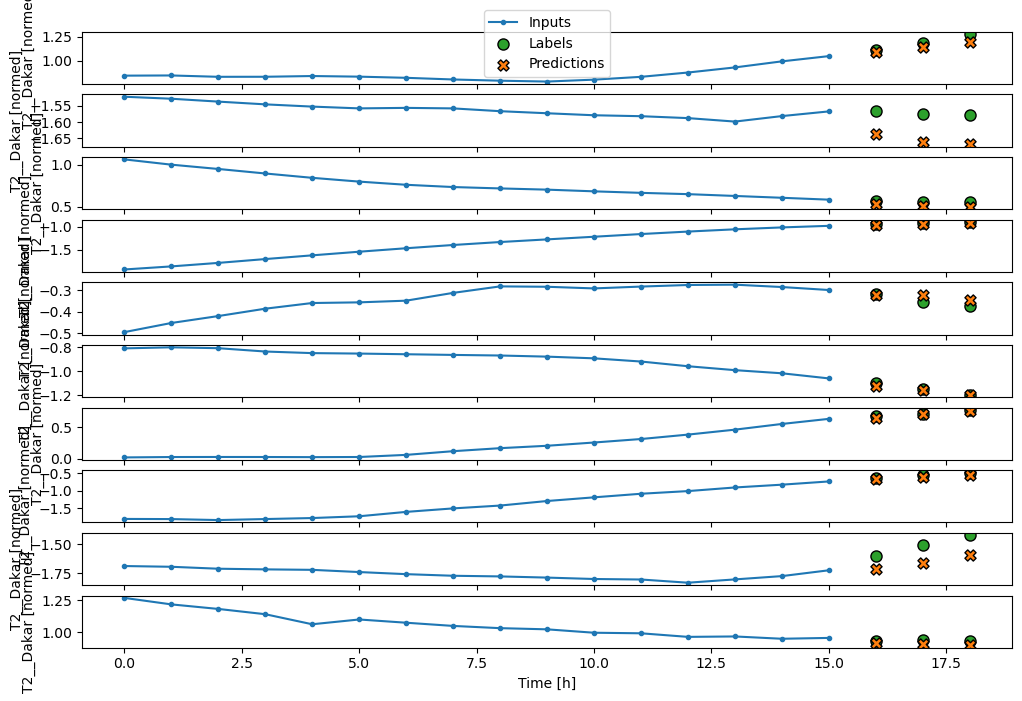

In [87]:
multi_window_dakarandpout.plot(multi_lstm_model, max_subplots=10)
#plot_col_input='RAIN_cumulative__Dakar', plot_col_label='RAIN_cumulative__Dakar',

In [59]:
multi_window_dakarandpout

Total window size: 19
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [16 17 18]
Input column name(s): ['T2__Dakar', 'Q2__Dakar', 'U10__Dakar', 'V10__Dakar', 'PSFC__Dakar', 'T2__Pout', 'Q2__Pout', 'U10__Pout', 'V10__Pout', 'PSFC__Pout']
Label column name(s): ['T2__Dakar']

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [60]:
out_steps=3
OUT_STEPS=out_steps
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(5)

In [61]:
feedback_model = FeedBack(units=100, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [62]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

TensorShape([32, 5])

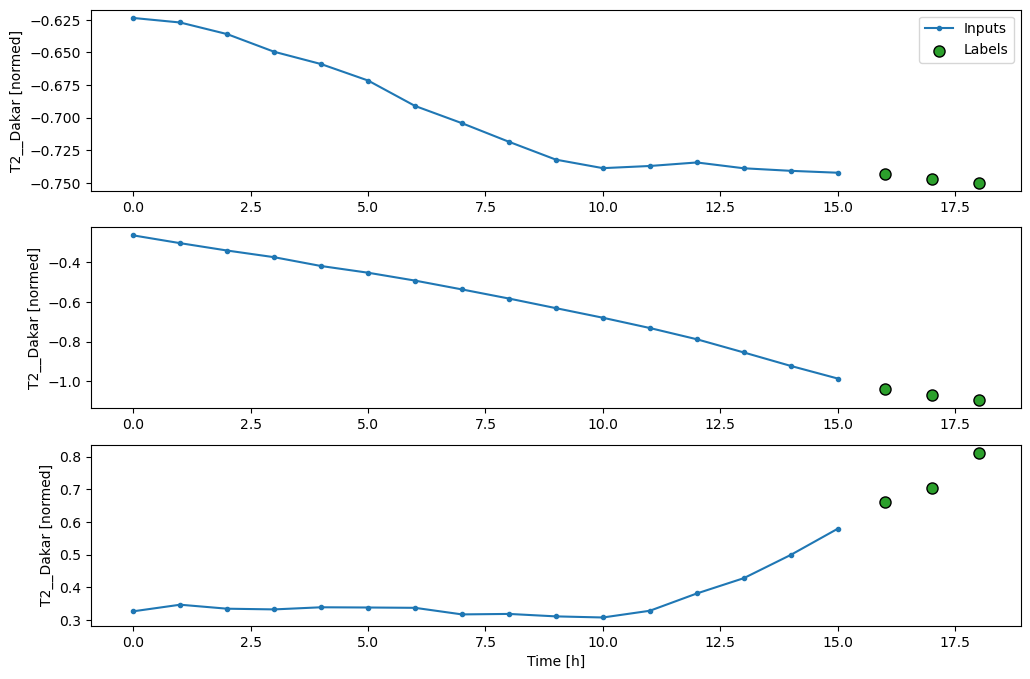

In [63]:
OUT_STEPS = out_steps
multi_window_dakaronly = WindowGenerator(input_width=16,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               input_columns=["T2__Dakar","Q2__Dakar", "U10__Dakar", "V10__Dakar", "PSFC__Dakar"],
                               label_columns=["T2__Dakar"]
)
#input_columns=["T2__Dakar", "Q2__Dakar", "U10__Dakar", "V10__Dakar", "PSFC__Dakar","T2__Pout", "Q2__Pout", "U10__Pout", "V10__Pout", "PSFC__Pout"],
#label_columns=["T2__Dakar"]
multi_window_dakaronly.plot()
multi_window

num_features = 5

prediction, state = feedback_model.warmup(multi_window_dakaronly.example[0])
prediction.shape

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [64]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [65]:
print('Output shape (batch, time, features): ', feedback_model(multi_window_dakaronly.example[0]).shape)

Output shape (batch, time, features):  (32, 3, 5)


Now, train the model:

144/144 [==============================] - 0s 3ms/step - loss: 0.0261 - mean_absolute_error: 0.0840


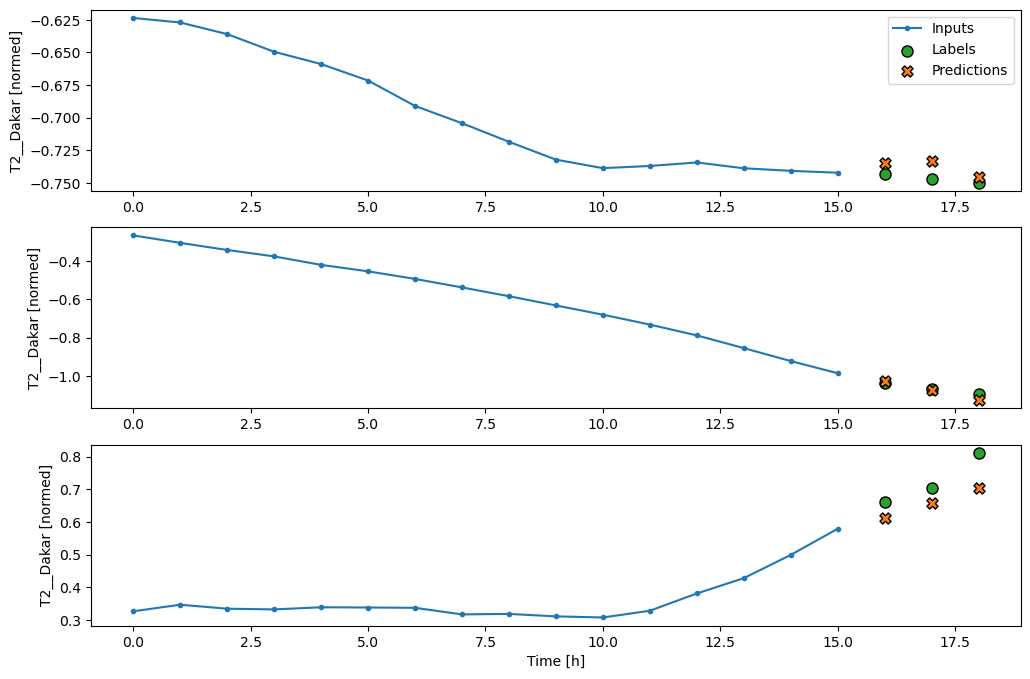

In [66]:
history = compile_and_fit(feedback_model, multi_window_dakaronly)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window_dakaronly.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window_dakaronly.test, verbose=0)
multi_window_dakaronly.plot(feedback_model)

TensorShape([32, 5])

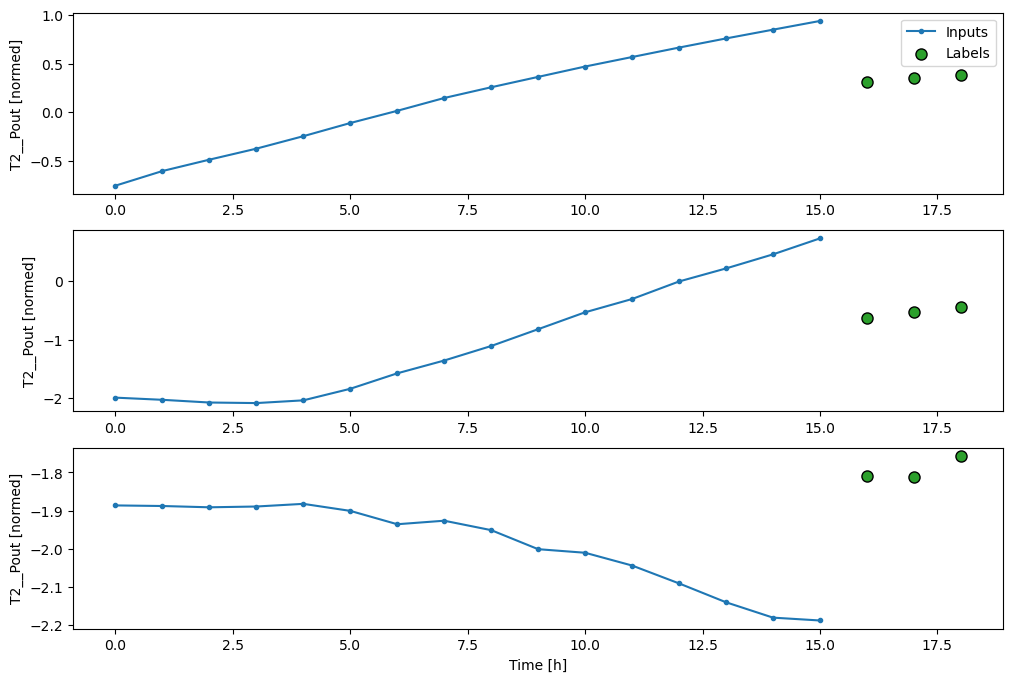

In [67]:
OUT_STEPS = out_steps
multi_window_poutonly = WindowGenerator(input_width=16,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               input_columns=["T2__Pout","Q2__Pout", "U10__Pout", "V10__Pout", "PSFC__Pout"],
                               label_columns=["T2__Dakar"]
)
#input_columns=["T2__Dakar", "Q2__Dakar", "U10__Dakar", "V10__Dakar", "PSFC__Dakar","T2__Pout", "Q2__Pout", "U10__Pout", "V10__Pout", "PSFC__Pout"],
#label_columns=["T2__Dakar"]
multi_window_poutonly.plot(plot_col_input='T2__Pout')
multi_window

num_features = 5

prediction, state = feedback_model.warmup(multi_window_poutonly.example[0])
prediction.shape

144/144 [==============================] - 0s 3ms/step - loss: 0.3343 - mean_absolute_error: 0.3556


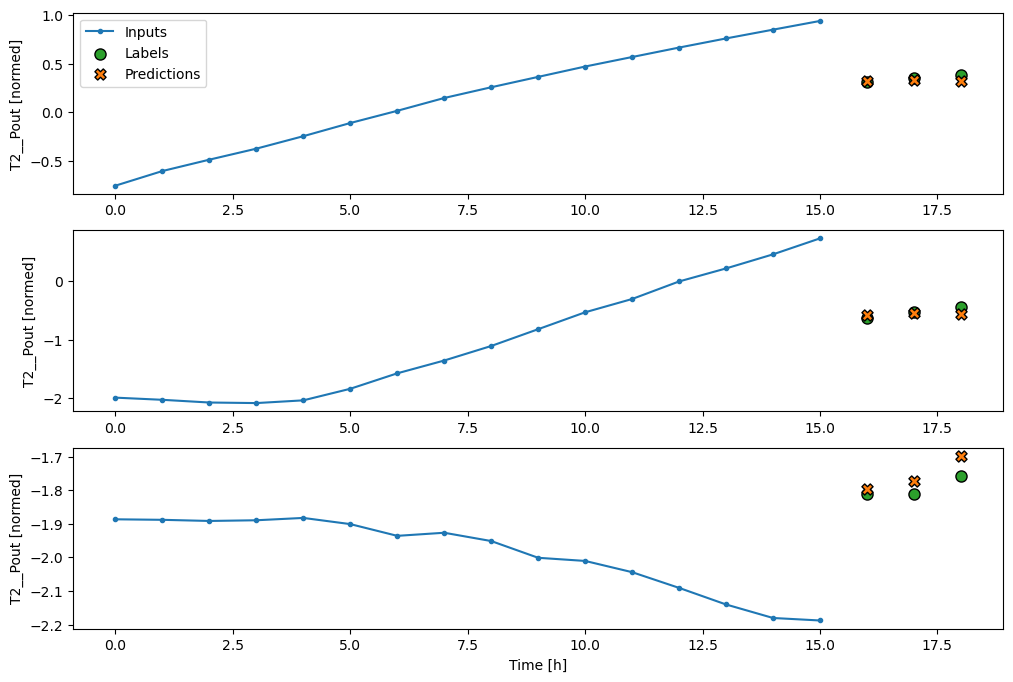

In [68]:
history = compile_and_fit(feedback_model, multi_window_poutonly)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window_poutonly.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window_poutonly.test, verbose=0)
multi_window_poutonly.plot(feedback_model, plot_col_input='T2__Pout')

In [69]:
out_steps=3
num_features=10
OUT_STEPS=out_steps
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(10)

In [70]:
feedback_model = FeedBack(units=100, out_steps=OUT_STEPS)

In [71]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

TensorShape([32, 10])

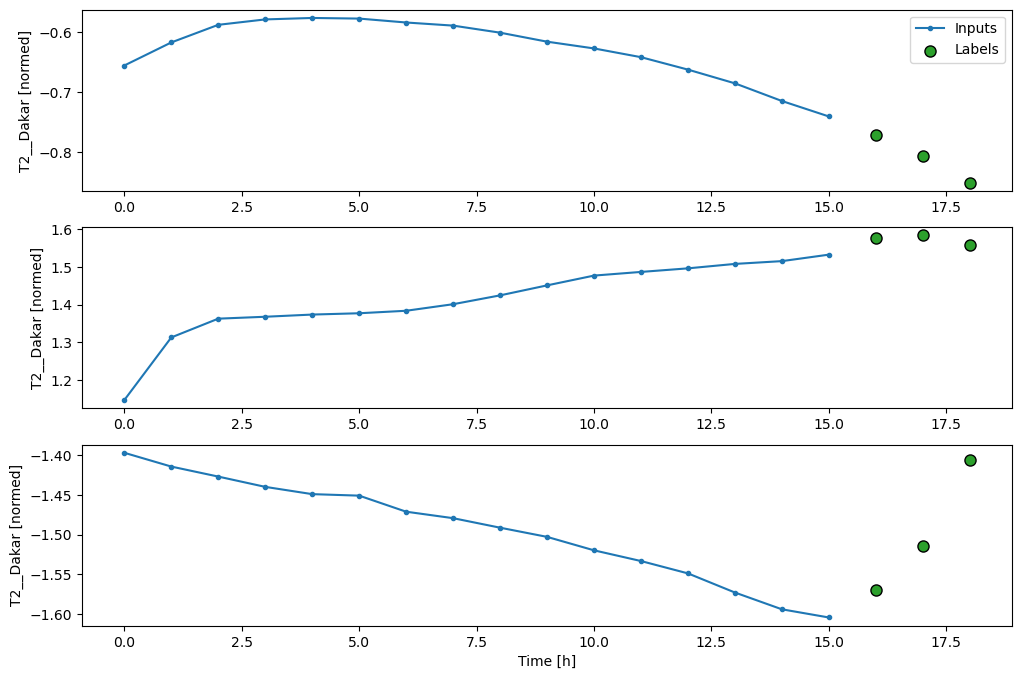

In [72]:
OUT_STEPS = out_steps
multi_window_dakarandpout = WindowGenerator(input_width=16,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               input_columns=["T2__Dakar", "Q2__Dakar", "U10__Dakar", "V10__Dakar", "PSFC__Dakar","T2__Pout","Q2__Pout", "U10__Pout", "V10__Pout", "PSFC__Pout"],
                               label_columns=["T2__Dakar"]
)
#input_columns=["T2__Dakar", "Q2__Dakar", "U10__Dakar", "V10__Dakar", "PSFC__Dakar","T2__Pout", "Q2__Pout", "U10__Pout", "V10__Pout", "PSFC__Pout"],
#label_columns=["T2__Dakar"]
multi_window_dakarandpout.plot()


num_features = 10

prediction, state = feedback_model.warmup(multi_window_dakarandpout.example[0])
prediction.shape

In [73]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

144/144 [==============================] - 0s 3ms/step - loss: 0.0514 - mean_absolute_error: 0.1212


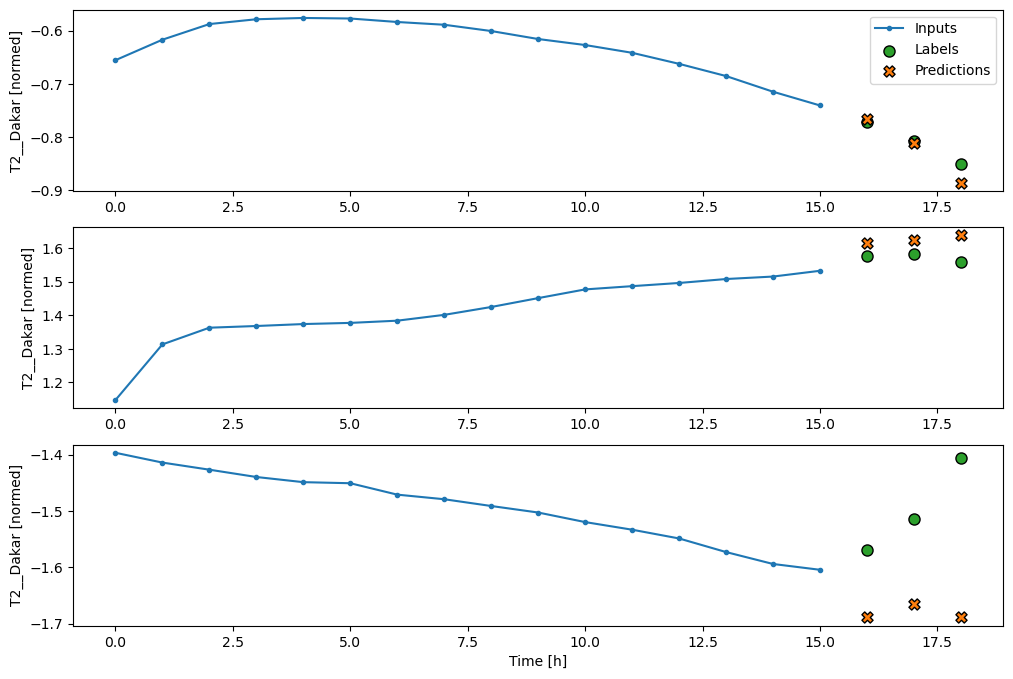

In [74]:
history = compile_and_fit(feedback_model, multi_window_dakarandpout)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window_dakarandpout.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window_dakarandpout.test, verbose=0)
multi_window_dakarandpout.plot(feedback_model)

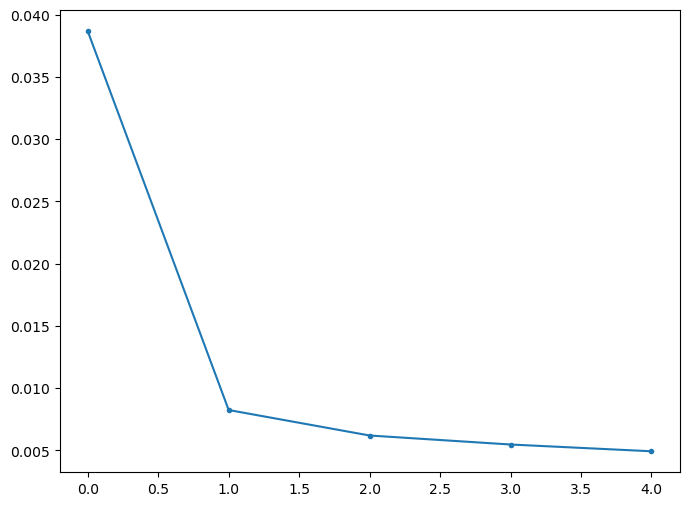

In [75]:
plt.plot(history.history['loss'], marker=".")

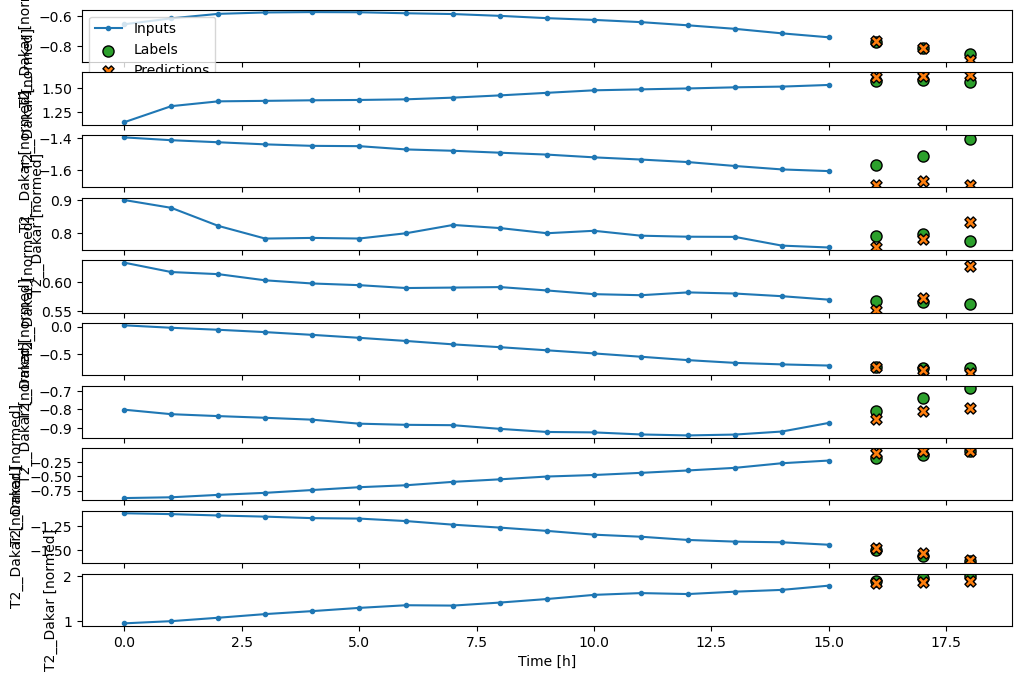

In [76]:
multi_window_dakarandpout.plot(feedback_model, plot_col_input='T2__Dakar', plot_col_label='T2__Dakar', max_subplots=10)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

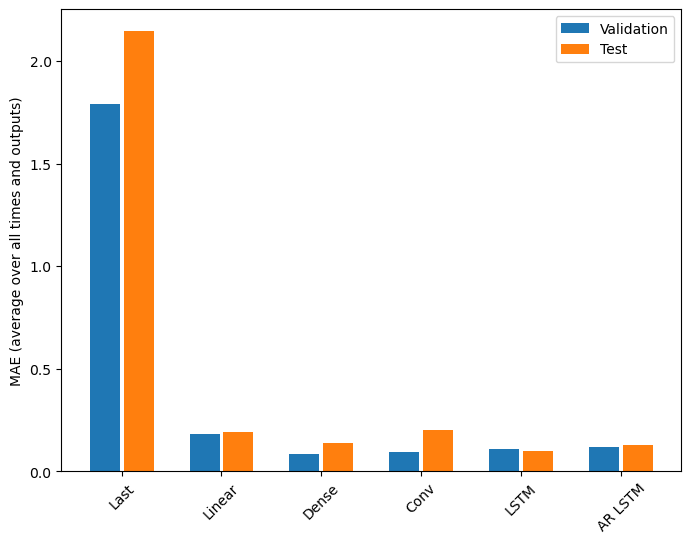

In [77]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps. 

In [78]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 2.1452
Linear  : 0.1925
Dense   : 0.1381
Conv    : 0.1998
LSTM    : 0.1014
AR LSTM : 0.1306


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.
